In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import scanpy
import os
import pandas as pd
import numpy as np
import scipy as sp
import scipy.stats
import matplotlib.pyplot as plt
import seaborn as sns
import json

In [2]:
def load_fry(frydir, which_counts=['S','A'], verbose=False):
    import json
    import os
    meta_info = json.load(open(os.path.sep.join([frydir, "meta_info.json"])))
    ng = meta_info['num_genes']
    usa_mode = meta_info['usa_mode']

    if usa_mode:
        assert(len(which_counts) > 0)
        if verbose:
            print("processing input in USA mode, will return {}".format("+".join(which_counts)))
    elif verbose:
        print("processing input in standard mode, will return spliced count")

    af_raw = scanpy.read_mtx(os.path.sep.join([frydir, "alevin", "quants_mat.mtx"]))
    ng = int(ng/3) if usa_mode else ng
    afg = [ l.rstrip() for l in open(os.path.sep.join([frydir, "alevin", "quants_mat_cols.txt"])).readlines()][:ng]
    afg_df =  pd.DataFrame(afg, columns=["gene_ids"])
    afg_df = afg_df.set_index("gene_ids")
    
    abc = [ l.rstrip() for l in open(os.path.sep.join([frydir, "alevin", "quants_mat_rows.txt"])).readlines() ]
    abc_df = pd.DataFrame(abc, columns=['barcodes'])
    abc_df.index = abc_df['barcodes']
    
    x = af_raw.X
    if usa_mode:
        rd = {'S' : range(0,ng), 'U' : range(ng, 2*ng), 'A' : range(2*ng,3*ng)}
        o = x[:, rd[which_counts[0]]]
        for wc in which_counts[1:]:
            o += x[:, rd[wc]]
    else:
        o = x
        
    af = scanpy.AnnData(o.T, var=abc_df, obs=afg_df)
    af = af.T
    return af

In [3]:
def read_sim(simdir):
    cf = 'cells.tsv'
    gf = 'genes.tsv'
    mf = 'matrix.mtx'
    
    sim_raw = scanpy.read_mtx(os.path.sep.join([simdir, mf]))
    genes = [ l.rstrip() for l in open(os.path.sep.join([simdir, gf])).readlines() ]
    genes_df = pd.DataFrame(genes, columns=["gene_ids"])
    genes_df = genes_df.set_index("gene_ids")
    
    barcodes = [ l.rstrip() for l in open(os.path.sep.join([simdir, cf])).readlines()]
    barcodes_df = pd.DataFrame(barcodes, columns=["barcodes"])
    barcodes_df = barcodes_df.set_index("barcodes")
    
    mat = scanpy.AnnData(sim_raw.X, var=barcodes_df, obs=genes_df)
    mat = mat.T
    return mat

In [4]:
def sp_corr_df(d1, d2, shared, shared_cells, kind="cells", thresh=1):
    '''
    Given 2 AnnData objects, a list of shared genes `shared` and 
    a list of shared cells `shared_cells`, compute the pariwise spearman 
    correlation of type `kind`.  If `kind` is "cells", then compute the 
    cellwise spearman correlations, if it is "genes" compute the genewise
    spearman correlations.  The result is a distribution (list) of correlation
    values.
    '''
    a = d1[shared_cells, shared].X.copy()
    b = d2[shared_cells, shared].X.copy()
    if kind == "cells":
        corrs = np.zeros(len(shared_cells))
        for i,c in enumerate(shared_cells):
            sr,p = sp.stats.spearmanr(a[i,:].toarray()[0], b[i,:].toarray()[0])
            corrs[i]=sr
    elif kind == "genes":
        a = a.T.tocsr()
        b = b.T.tocsr()
        corrs = np.zeros(len(shared))
        for i,c in enumerate(shared):
            sr,p = scipy.stats.spearmanr(a[i,:].toarray()[0], b[i,:].toarray()[0])
            corrs[i]=sr
    return corrs


In [5]:
def maximum (A, B):
    '''
    Select the maximum, entry-wise among matricies A and B.    
    '''
    # https://stackoverflow.com/questions/19311353/element-wise-maximum-of-two-sparse-matrices
    BisBigger = A-B
    BisBigger.data = np.where(BisBigger.data < 0, 1, 0)
    return A - A.multiply(BisBigger) + B.multiply(BisBigger)

In [6]:
def get_metrics(truth, pred_in):
    '''
    Compute and return the metrics we are evaluating.
    '''  
    shared_obs = pred_in.obs.index.intersection(truth.obs.index)
    shared_var = pred_in.var.index.intersection(truth.var.index)

    truth_filt = truth[shared_obs, shared_var].copy()
    pred = pred_in[shared_obs, shared_var].copy()
    entry_rd = (pred.X - truth_filt.X) / maximum(truth_filt.X, pred.X)
    entry_ard_nonan = np.abs(entry_rd[~np.isnan(entry_rd)])
    mard_drop_nan = entry_ard_nonan.mean()
    
    entry_rdc = entry_rd.copy()
    entry_rdc[np.isnan(entry_rdc)] = 0.0
    mard_nan_zero = np.abs(entry_rdc).mean()
    
    spearmans = sp_corr_df(truth_filt, pred, pred.var_names, pred.obs_names)
    
    fps = [np.logical_and(truth_filt.X[i,:].toarray() == 0, pred.X[i,:].toarray() > 0).sum() for i in range(pred.X.shape[0])]
    num_expressed = [ np.sum(truth_filt.X[i,:].toarray() > 0) for i in range(pred.X.shape[0])]
    
    fp_gene_per_cell = np.mean(np.array(fps)/np.array(num_expressed))
  
    fns = [np.logical_and(truth_filt.X[i,:].toarray() > 0, pred.X[i,:].toarray() == 0).sum() for i in range(pred.X.shape[0])]
    #num_expressed = [ np.sum(truth_filt.X[i,:].toarray() > 0) for i in range(pred.X.shape[0])]
    
    fn_gene_per_cell = np.mean(np.array(fns)/np.array(num_expressed))
    
    rd = {'rd' : entry_rd, 'mard' : mard_nan_zero, 'mard_drop_nan' : mard_drop_nan,
          'spearmans' : spearmans, 'fp_gene_per_cell' : fp_gene_per_cell, 
          'fn_gene_per_cell' : fn_gene_per_cell}
    return rd

In [7]:
def print_summary_metrics(resdict):
    print('Mean per-cell Spearman correlation: {:.4f}'.format(resdict['spearmans'].mean()))
    print('MARD (dropping NANs) : {:.4f}'.format(resdict['mard_drop_nan']))
    print('MARD (setting NANs = 0) : {:.4f}'.format(resdict['mard']))
    print('rFP / cell : {:.4f}%'.format(100*resdict['fp_gene_per_cell']))
    print('rFN / cell : {:.4f}%'.format(100*resdict['fn_gene_per_cell']))

In [8]:
def get_shared(list_of_annd):
    shared_cells = list_of_annd[0].obs_names
    shared_genes = list_of_annd[0].var_names
    for annd in list_of_annd[1:]:
        shared_cells &= annd.obs_names
        shared_genes &= annd.var_names 
    return shared_cells, shared_genes

In [9]:
def legend_without_duplicate_labels(ax, loc='lower right'):
    '''
    from : https://stackoverflow.com/questions/19385639/duplicate-items-in-legend-in-matplotlib
    '''
    handles, labels = ax.get_legend_handles_labels()
    unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
    ax.legend(*zip(*unique), loc=loc)

In [10]:
colors = {'STARsolo' : (200/255.0, 184/255.0, 114/255.0), 
          'alevin-fry (splici, sketch)' : (106/255.0, 123/255.0, 197/255.0) , 
          'alevin-fry (txome, sketch)' : (117/255.0, 0/255.0, 117/255.0), 
          'kallisto|bustools' : (191/255.0, 114/255.0, 106/255.0), 
          'alevin-fry (splici, sla)' : (0/255.0, 118/255.0, 0/255.0)}

In [11]:
def get_res_summary(mdict):
    datalist = []
    for mn, m in mdict.items():
        datalist.append((mn, m['spearmans'].mean(), m['mard_drop_nan'], m['mard'], m['fp_gene_per_cell'], m['fn_gene_per_cell']))
    
    data = pd.DataFrame.from_records(datalist, 
        columns=['method', 'mean Spearman corr.', 'MARD (drop NA)', 'MARD (NA=0)', 'rFP/cell', 'rFN/cell'])
    return data

In [12]:
def plot_nz_decay(md, shared_genes, shared_cells):
    sns.set_context('paper')#, font_scale=1.4, rc={"lines.linewidth": 2})
    sns.set_style('whitegrid')
    fig, ax = plt.subplots()
    for k,v in md.items():
        nnz = v[shared_cells, shared_genes].X.getnnz(axis=0)
        nnz.sort()
        nnz = nnz[::-1]
        ax.plot(nnz, c=colors[k], label=k)
    fig.set_size_inches(10, 6)
    fig.set_dpi(300)
    plt.yscale('log')
    plt.ylabel('# cells in which a gene is present')
    plt.xlabel('gene rank by frequency')
    plt.legend()

In [15]:
top_path = None
with open('config.json') as f:
    config = json.load(f)
    top_path = config['top_dir']
    truth_path = config['truth_dir']

In [17]:
truth = read_sim(truth_path)

In [31]:
fry_results = {}

In [73]:
fry_results

{85: AnnData object with n_obs × n_vars = 4789 × 33540
     obs: 'barcodes',
 90: AnnData object with n_obs × n_vars = 4789 × 33540
     obs: 'barcodes',
 95: AnnData object with n_obs × n_vars = 4789 × 33540
     obs: 'barcodes',
 100: AnnData object with n_obs × n_vars = 4789 × 33540
     obs: 'barcodes',
 105: AnnData object with n_obs × n_vars = 4789 × 33540
     obs: 'barcodes',
 110: AnnData object with n_obs × n_vars = 4789 × 33540
     obs: 'barcodes',
 115: AnnData object with n_obs × n_vars = 4789 × 33540
     obs: 'barcodes',
 120: AnnData object with n_obs × n_vars = 4789 × 33540
     obs: 'barcodes',
 125: AnnData object with n_obs × n_vars = 4789 × 33540
     obs: 'barcodes',
 130: AnnData object with n_obs × n_vars = 4789 × 33540
     obs: 'barcodes',
 135: AnnData object with n_obs × n_vars = 4789 × 33540
     obs: 'barcodes',
 145: AnnData object with n_obs × n_vars = 4789 × 33540
     obs: 'barcodes'}

In [77]:
for i in range(85, 150, 5):
    path = "/mnt/scratch1/mohsen/salmon_indices/salmon_sim_data/salmon_fl"+str(i)+"_sparse/quant_knee_cr-like/"
    if os.path.isdir(path) and i not in fry_results:
        print(path)
        fry_results[i] = load_fry(path)

/mnt/scratch1/mohsen/salmon_indices/salmon_sim_data/salmon_fl140_sparse/quant_knee_cr-like/


In [75]:
spearmans = {}
mards_drop_nan = {}
mards = {}
fps = {}
fns = {}

In [78]:
for i in range(140, 145, 5):
    if i in fry_results:
        print(i)
        shared_cells, shared_genes = get_shared([truth, fry_results[i]])
        splici_res = get_metrics(truth[shared_cells, shared_genes], fry_results[i][shared_cells, shared_genes])
        spearmans[i] = splici_res['spearmans'].mean()
        mards_drop_nan[i] = splici_res['mard_drop_nan']
        mards[i] = splici_res['mard']
        fps[i] = splici_res['fp_gene_per_cell']
        fns[i] = splici_res['fn_gene_per_cell']

140


In [108]:
all_df = pd.DataFrame(columns = ['flank-length', 'spearman', 'mard_drop_nan', 'fp', 'fn'])
for key in spearmans:
    all_df = all_df.append({'flank-length': key, 'spearman' : spearmans[key], \
                           'mard_drop_nan' : mards_drop_nan[key], \
                           'fp' : fps[key], 'fn' : fns[key]}, ignore_index=True)

In [109]:
all_df

,flank-length,spearman,mard_drop_nan,fp,fn
0,85.0,0.988318,0.026321,0.010969,0.011832
1,90.0,0.988337,0.026280,0.010935,0.011830
2,95.0,0.988346,0.026261,0.010916,0.011830
3,100.0,0.988355,0.026242,0.010897,0.011832
4,105.0,0.988367,0.026216,0.010872,0.011832
5,110.0,0.988375,0.026199,0.010854,0.011834
6,115.0,0.988381,0.026189,0.010842,0.011836
7,120.0,0.988389,0.026172,0.010825,0.011836
8,125.0,0.988404,0.026144,0.010794,0.011837
9,130.0,0.988437,0.026081,0.010733,0.011836


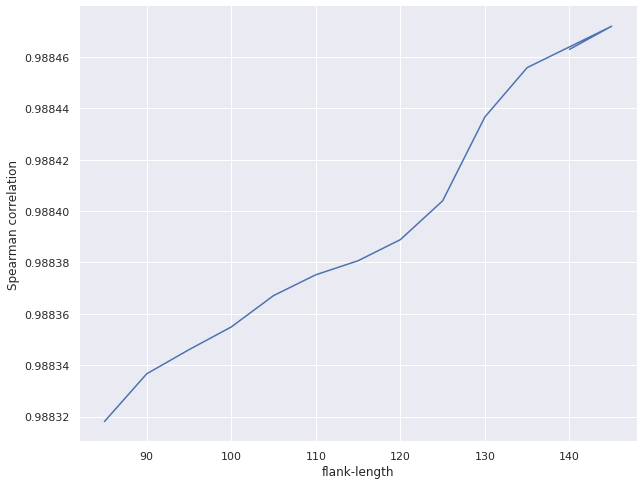

In [102]:
sns.set()
g = plt.plot(spearmans_df['flank-length'], spearmans_df['spearman'])
plt.xlabel('flank-length')
plt.ylabel('Spearman correlation')
fig = plt.gcf()
fig.set_size_inches(10,8)
sns.despine()

In [ ]:

sns.set()
g = plt.plot(spearmans_df['flank-length'], spearmans_df['spearman'])
plt.xlabel('flank-length')
plt.ylabel('Spearman correlation')
fig = plt.gcf()
fig.set_size_inches(10,8)
sns.despine()